In [1]:
import os
import time
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import font_manager
from livelossplot.keras import PlotLossesCallback
from tensorflow.python.client import device_lib
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from crnn_model_v1 import CRNN
from crnn_data_v1 import InputGenerator, modified_gen
from utils.training import Logger
from utils.gt_util import GTUtility

In [2]:
devices = device_lib.list_local_devices()
device_types = [device.device_type for device in devices]
if 'GPU' in device_types:
    print("Current device type:           GPU")
else:
    print("Current device type:           CPU")

current_directory = os.getcwd()
os.chdir(current_directory)
print(f"Current working directory:    ", os.getcwd())

font_path = 'fonts/NanumBarunGothic.ttf'
font_prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['font.sans-serif'] = ['NanumBarunGothic']
print("Current font name:            ", plt.rcParams['font.family'])

Current device type:           GPU
Current working directory:     c:\Users\pja36\OneDrive\Desktop\Project\Model.v2
Current font name:             ['NanumBarunGothic']


In [3]:
base_path = 'data/text_in_the_wild_data/'
model_name = 'crnn_model_20231001'
from models.hyper_param_v12 import (ocr_dict, leaky, fctc, drop, batch_size, input_shape, max_string_len, 
                        lr, decay, momentum, clipnorm, epoch, freeze, opt)

print(f"Model Name: {model_name.upper()}")
print("---------------------------------")
print("Model Type: CRNN")
print("Model Param:")
print(f"    epoch:         {epoch}")
print(f"    batch_size:    {batch_size}")
print(f"    leaky ReLU:    {leaky}")
print(f"    focal CTC:     {fctc}")
print(f"    dropout:       {drop}")
print(f"    freeze:        {freeze if freeze else 'None'}")
print("---------------------------------")
print(f"Optimizer: {opt}")
print("Optimizer Param:")
print(f"    learning rate: {lr}")
print(f"    decay:         {decay}")
print(f"    momentum(SGD): {momentum}")
print(f"    clipnorm:      {clipnorm}")

Model Name: CRNN_MODEL_20231001
---------------------------------
Model Type: CRNN
Model Param:
    epoch:         300
    batch_size:    128
    leaky ReLU:    0.1
    focal CTC:     (0.25, 0.75)
    dropout:       None
    freeze:        None
---------------------------------
Optimizer: Adam
Optimizer Param:
    learning rate: 0.001
    decay:         0.001
    momentum(SGD): 0.9
    clipnorm:      1.0


In [4]:
with open(base_path + 'gt_train_util_text.pkl', 'rb') as f:
    gt_train_util = pickle.load(f)
gen_train = InputGenerator(gt_train_util, batch_size, ocr_dict, input_shape[:2], 
                        grayscale=True, max_string_len=max_string_len, concatenate=False, fctc=fctc)
print("Total number of train data samples:        ", gen_train.num_samples)

with open(base_path + 'gt_val_util_text.pkl', 'rb') as f:
    gt_val_util = pickle.load(f)
gen_val = InputGenerator(gt_val_util, batch_size, ocr_dict, input_shape[:2], 
                        grayscale=True, max_string_len=max_string_len, concatenate=False, fctc=fctc)
print("Total number of validation data samples:   ", gen_val.num_samples)

Total number of train data samples:         23999
Total number of validation data samples:    8000


In [5]:
model, model_pred = CRNN(input_shape, len(ocr_dict), leaky=leaky, fctc=fctc, drop=drop, gru=False)
#model_path = 'models/'
#model_name = 'leaky_fctc_weights.044.h5'
#model.load_weights(model_path + model_name)

if opt == 'Adam': 
        optimizer = Adam(learning_rate=lr, decay=decay, clipnorm=clipnorm)
else: optimizer = SGD(learning_rate=lr, decay=decay, clipnorm=clipnorm, momentum=momentum, nesterov=True)

for layer in model.layers:
        layer.trainable = not layer.name in freeze

key = 'focal_ctc' if fctc else 'ctc'
model.compile(loss={key: lambda y_true, y_pred: y_pred}, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 256, 32, 1)] 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 256, 32, 64)  640         image_input[0][0]                
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 128, 16, 64)  0           conv1_1[0][0]                    
__________________________________________________________________________________________________
conv2_1 (Conv2D)                (None, 128, 16, 128) 73856       pool1[0][0]                      
____________________________________________________________________________________________

In [6]:
experiment = model_name
checkdir = './checkpoints/' + time.strftime('%Y%m%d%H%M') + '_' + experiment
if not os.path.exists(checkdir):
    os.makedirs(checkdir)

with open(checkdir+'/source.py','wb') as f:
    source = ''.join(['# In[%i]\n%s\n\n' % (i, In[i]) for i in range(len(In))])
    f.write(source.encode())

In [7]:
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
hist = model.fit(modified_gen(gen_train.generate(), fctc),
                steps_per_epoch=gt_train_util.num_objects // batch_size,
                epochs=epoch,
                validation_data=modified_gen(gen_val.generate(), fctc),
                validation_steps=gt_val_util.num_objects // batch_size,
                callbacks=[
                    ModelCheckpoint(checkdir+'/weights.{epoch:03d}.h5', 
                                    verbose=1, 
                                    save_weights_only=True),
                    Logger(checkdir),
                    tensorboard_callback,
                    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    mode='auto', 
                                                    restore_best_weights=True, 
                                                    verbose=1, 
                                                    patience=20)
                ],
                initial_epoch=0)

NEW epoch
Epoch 1/300
3219/3219 [==============================] - ETA: 0s - loss: 1.6341 - accuracy: 0.3010NEW epoch
NEW epoch
NEW epoch
3219/3219 [==============================] - 1101s 338ms/step - loss: 1.6341 - accuracy: 0.3010 - val_loss: 0.7175 - val_accuracy: 0.6430

Epoch 00001: saving model to ./checkpoints/202310012153_crnn_model_20231001\weights.001.h5
Epoch 2/300
3219/3219 [==============================] - 1075s 334ms/step - loss: 0.5509 - accuracy: 0.7398 - val_loss: 0.4404 - val_accuracy: 0.8000

Epoch 00002: saving model to ./checkpoints/202310012153_crnn_model_20231001\weights.002.h5
Epoch 3/300
NEW epoch
3219/3219 [==============================] - 1080s 336ms/step - loss: 0.3929 - accuracy: 0.8244 - val_loss: 0.3709 - val_accuracy: 0.8392

Epoch 00003: saving model to ./checkpoints/202310012153_crnn_model_20231001\weights.003.h5
Epoch 4/300
3219/3219 [==============================] - 1083s 337ms/step - loss: 0.3270 - accuracy: 0.8584 - val_loss: 0.3316 - val_accur

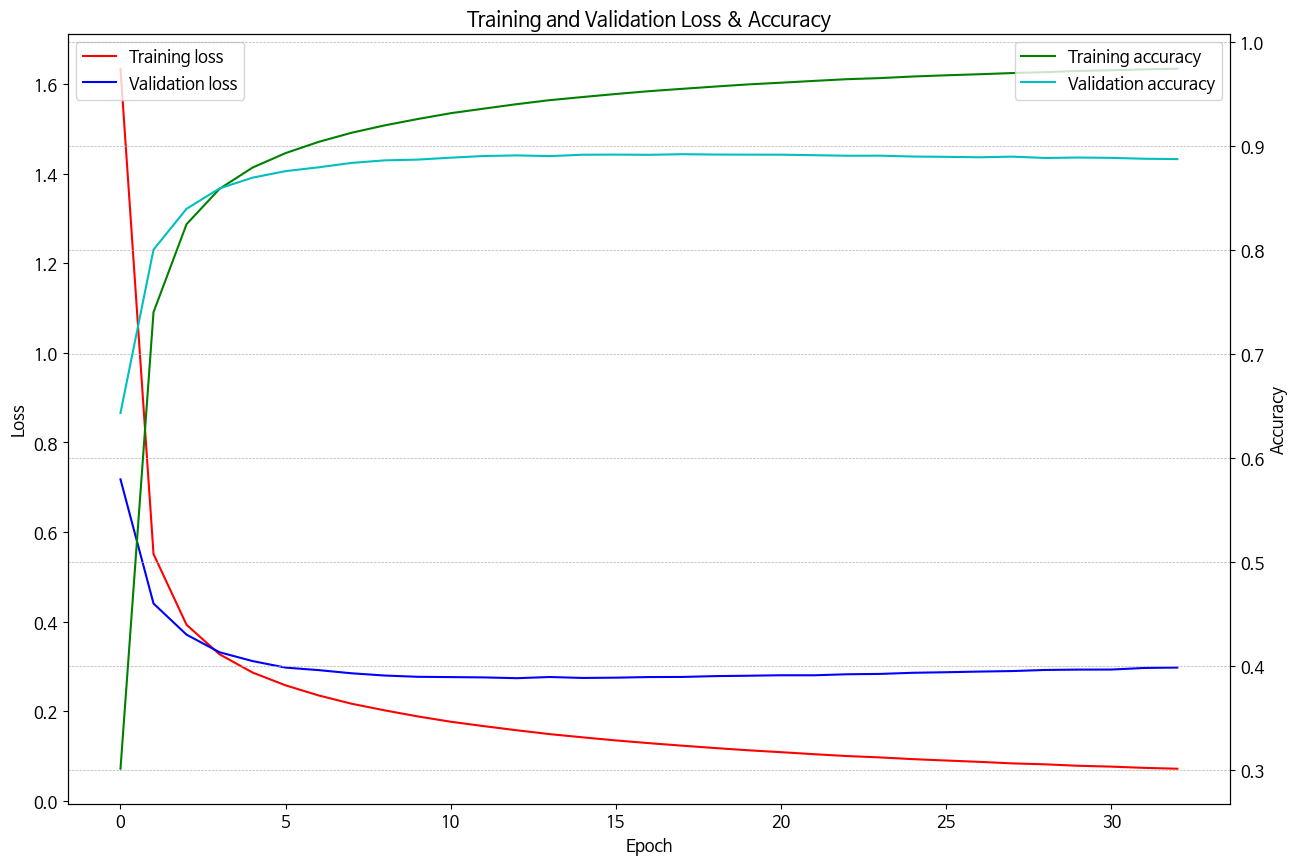

In [8]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

epochs = range(len(loss))
plt.figure(figsize=(15,10))

ax1 = plt.gca()
ax1.plot(epochs, loss, 'r', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.tick_params('y')

ax2 = ax1.twinx()
ax2.plot(epochs, accuracy, 'g', label='Training accuracy')
ax2.plot(epochs, val_accuracy, 'c', label='Validation accuracy')
ax2.set_ylabel('Accuracy')
ax2.tick_params('y')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Training and Validation Loss & Accuracy')
plt.show()